In [1]:
%load_ext autoreload

In [2]:
%autoreload
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

sys.path.append('../src/')
from indicators import *

%matplotlib inline

Read a dataframe that has only EU organisations and includes:
* People working in the EU
* Their degrees, job, ethnicity, gender

In [3]:
df = pd.read_csv('../data/processed/ojpd_scotland_v2.csv')

In [4]:
# Remove Nottingham from the analysis because of a geocoding error. 
df = df[df.city != 'Nottingham']
df['founded_on'] = df.founded_on.apply(lambda x: x[:4] if isinstance(x, str) else x)

## Very basic EDA

In [5]:
df.job_type.isnull().sum()

1787

In [6]:
df.drop_duplicates('person_id').job_type.value_counts()

executive         1171
employee           674
board_member       201
advisor             25
board_observer       6
Name: job_type, dtype: int64

In [7]:
# Missing values
df.isnull().sum() / df.shape[0]

org_id                 0.000000
funding_total_usd      0.608860
founded_on             0.119329
city                   0.000000
country                0.000000
employee_count         0.195328
primary_role           0.000000
country_alpha_2        0.000000
country_alpha_3        0.000000
continent              0.000000
latitude               0.000000
longitude              0.000000
job_id                 0.173226
is_current             0.173226
job_type               0.173226
category_group_list    0.089570
person_id              0.173226
first_name             0.173226
last_name              0.173226
gender                 0.186894
race                   0.173226
degree_type            0.668185
degree_id              0.628150
institution_id         0.628150
dtype: float64

In [8]:
print('NUMBER OF UNIQUE SCOTTISH COMPANIES: {}'.format(df[df.primary_role=='company'].org_id.unique().shape[0]))
print('NUMBER OF UNIQUE WORKERS IN SCOTTISH COMPANIES: {}'.format(df.person_id.unique().shape[0]))

NUMBER OF UNIQUE SCOTTISH COMPANIES: 1553
NUMBER OF UNIQUE WORKERS IN SCOTTISH COMPANIES: 2078


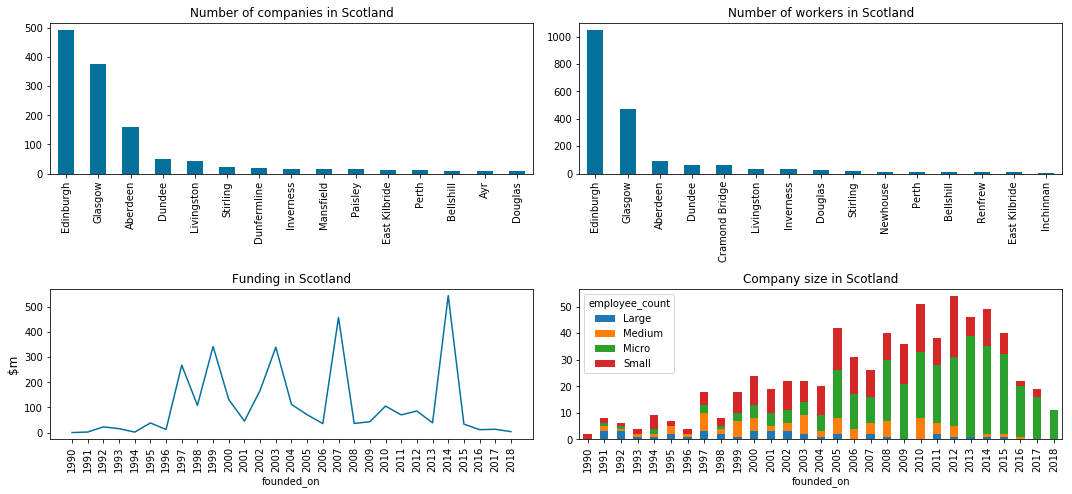

In [9]:
f = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(3, 2)

# ax1
ax1 = plt.subplot(gs[0, :1])
df[df.primary_role=='company'].drop_duplicates('org_id').city.value_counts()[:15].plot(kind='bar', color='xkcd:ocean blue', ax=ax1)
ax1.set_title('Number of companies in Scotland', fontsize=12)

# ax2
ax2 = plt.subplot(gs[0, 1:])
df.drop_duplicates('person_id').city.value_counts()[:15].plot(kind='bar', color='xkcd:ocean blue', ax=ax2)
ax2.set_title('Number of workers in Scotland', fontsize=12)

# ax3
ax3 = plt.subplot(gs[1, :1])
funding = df[df.primary_role=='company'].drop_duplicates('org_id').groupby('founded_on').sum()['funding_total_usd'].loc['1990':, ] / 1000000
funding.plot(color='xkcd:ocean blue', ax=ax3)
ax3.set_xticks(range(len(funding.index)))
ax3.set_xticklabels(list(funding.index), rotation=90)
ax3.set_title('Funding in Scotland', fontsize=12)
ax3.set_ylabel('$m', fontsize=12) 

# ax4
ax4 = plt.subplot(gs[1, 1:])
comp_size = df[df.primary_role=='company'].drop_duplicates('org_id').groupby(['founded_on', 'employee_count']).count()['org_id'].loc['1990':, ]
comp_size.unstack('employee_count').plot(kind='bar', stacked=True, ax=ax4)
ax4.set_xticks(range(len(comp_size.unstack('employee_count').index)))
ax4.set_xticklabels(list(comp_size.unstack('employee_count').index), rotation=90)
ax4.set_title('Company size in Scotland', fontsize=12)

plt.tight_layout()
plt.show()

## Indicators

In [10]:
ind = Indicators(df)

# 1. Gender diversity (city level)
country_gender = ind.people_diversity('city', 'gender')

# 2. Ethnic diversity (city level)
country_ethnicity = ind.people_diversity('city', 'race')

# 3. Gender distribution for degrees - city level
city_degree_gender = ind.degree_diversity('city', 'degree_type', 'gender', city_level=True, country='United Kingdom')

# 4. Ethnic distribution for degrees - city level
city_degree_ethnicity = ind.degree_diversity('city', 'degree_type', 'race', city_level=True, country='United Kingdom')

# 5. Gender diversity in roles
role_comp_gender = ind.city_role_company('city', 'job_type', 'gender')

# 6. Ethnic diversity in roles
role_comp_ethnicity = ind.city_role_company('city', 'job_type', 'race')

# 7. Gender diversity in categories (city level)
cat_comp_gender = ind.city_role_company('city', 'category_group_list', 'gender')

# 8. Ethnic diversity in categories (city level)
cat_comp_ethnicity = ind.city_role_company('city', 'category_group_list', 'race')

# 9. Gender diversity in categories
cat_gender = ind.city_role_company('category_group_list', 'gender')

# 10. Ethnic diversity in categories
cat_ethnicity = ind.city_role_company('category_group_list', 'race')

# 11. Lieberson index (intersectionality) - city level
data_formatting = ind.lieberson_format(['gender', 'race'], city_level=True, country='United Kingdom', thresh=60)
lieberson_index_cities = {k:ind.lieberson_index(v) for k, v in data_formatting.items()}

# 12. Studied at home vs abroad
work_and_study_place = ind.home_study('United Kingdom')

# 13. Simpson diversity - city level, ethnicity
simpson_ethnic_city = ind.simpson_index(type='race', thresh=60, country='United Kingdom')

# 14. Simpson diversity - city level, gender
simpson_gender_city = ind.simpson_index(type='gender', thresh=60, country='United Kingdom')

# 15. Ethnic diversity in gender
country_race_gender = ind.city_role_company('city', 'race', 'gender')

# Visualisation

### Indicators 1 & 2

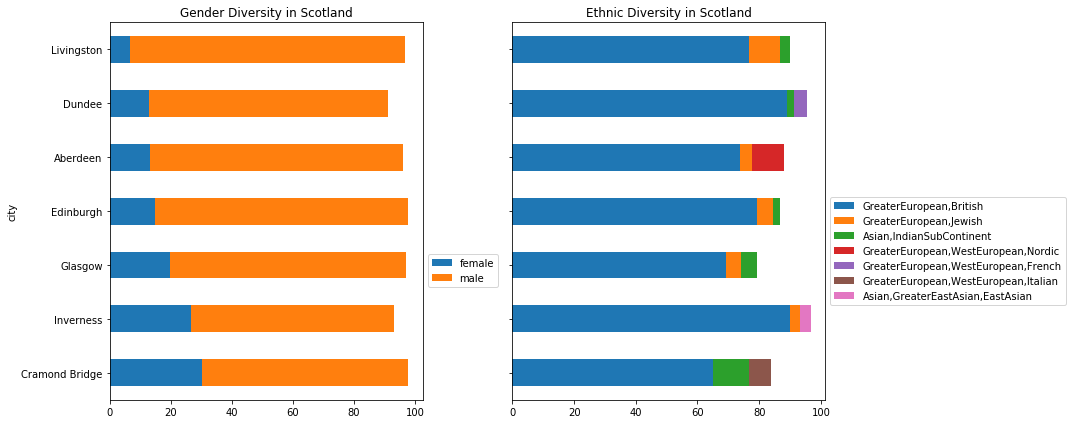

In [11]:
f = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(1, 2)

# ax1
idx = pd.IndexSlice
index = country_gender.loc[idx[:, 'female']].sort_values(ascending=False).index

ax1 = plt.subplot(gs[0, 0])
country_gender.unstack('gender').iloc[:15].reindex(index).plot(kind='barh', stacked=True, ax=ax1, legend=False)
ax1.set_title('Gender Diversity in Scotland', fontsize=12)
ax1.legend(bbox_to_anchor=(1, 0.4))

# ax2
ax2 = plt.subplot(gs[0, 1])
d = {}
for country in country_ethnicity.unstack('race').index[:15]:
    d[country] = country_ethnicity.unstack('race').loc[country].nlargest(n=3)
pd.DataFrame.from_dict(d, orient='index').reindex(country_gender.unstack('gender').index[:15].reindex(index)[0]).plot(kind='barh', stacked=True, ax=ax2)
ax2.set_title('Ethnic Diversity in Scotland', fontsize=12)
ax2.set_yticklabels([])
ax2.set_ylabel('')
ax2.legend(bbox_to_anchor=(1, 0.55))

plt.tight_layout()
plt.show()

### Indicators 3, 4, 5, 6, 7, 8 & 15

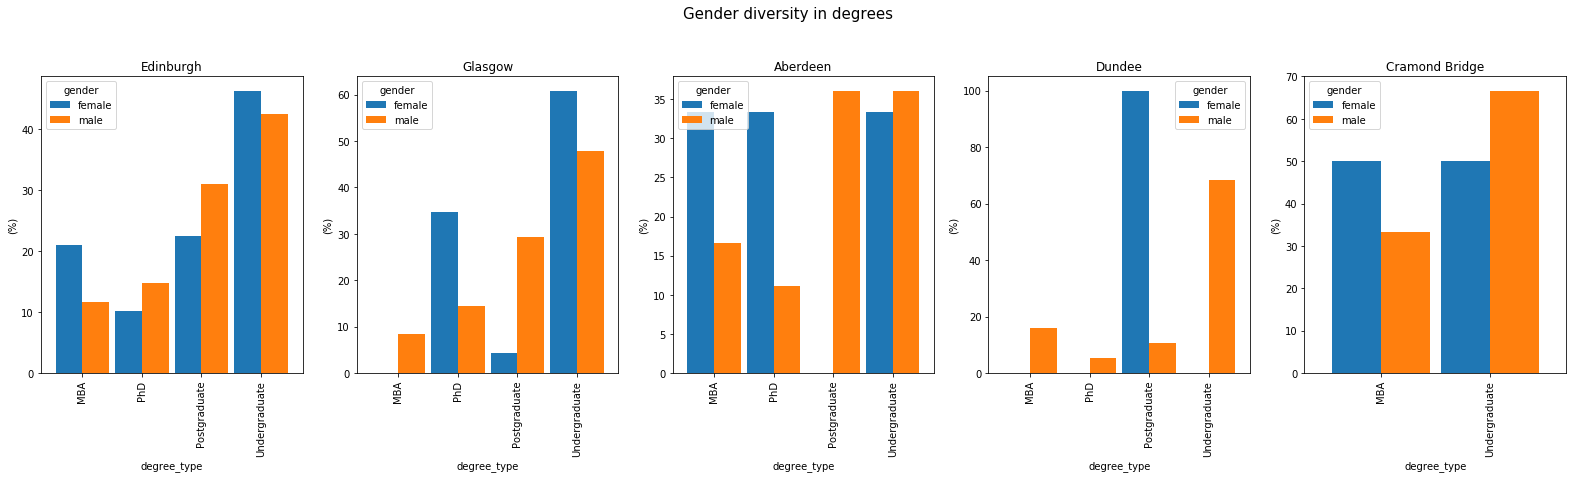

In [12]:
fig = plt.figure(figsize=(22, 6))
gs = gridspec.GridSpec(1,5)
for i, country in enumerate(country_gender.index.levels[0][:5]):
    ax = plt.subplot(gs[0,i])
    city_degree_gender.loc[country].unstack('gender')[['female', 'male']].plot(kind='bar', width=0.9, ax=ax)
    ax.set_title('{}'.format(country))
    ax.set_ylabel('(%)')

plt.suptitle('Gender diversity in degrees', fontsize=15, y=1.1)
plt.tight_layout()
plt.show()

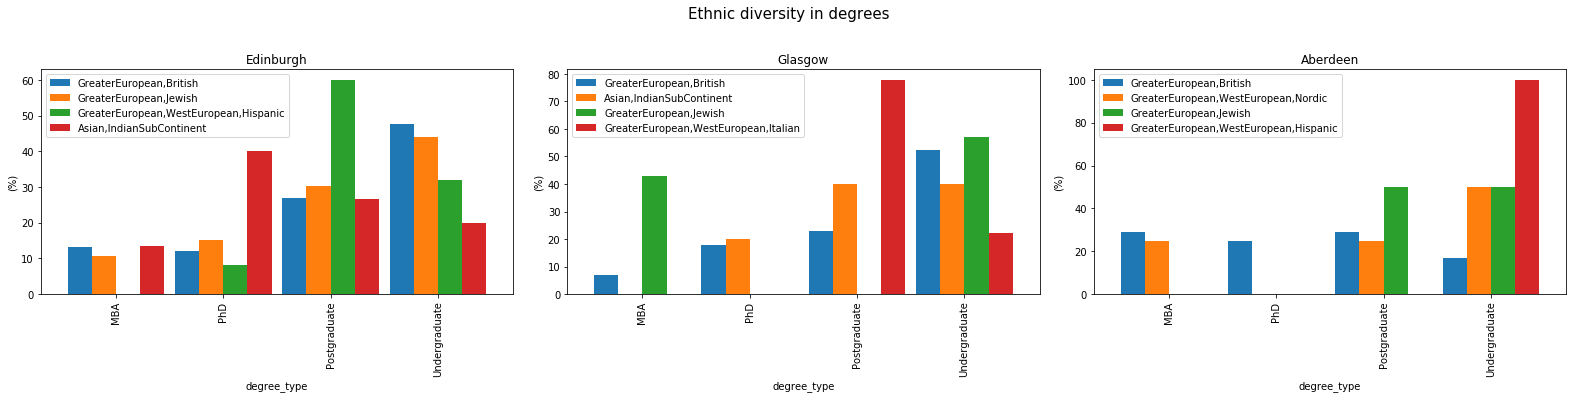

In [35]:
fig = plt.figure(figsize=(22, 5))
gs = gridspec.GridSpec(1,3)
for i, country in enumerate(city_degree_ethnicity.index.levels[0][:3]):
    ax = plt.subplot(gs[0,i])
    try:
        city_degree_ethnicity.loc[country].unstack('race')[[v for v in df[df.city==country].race.value_counts().index.values[:4]]].plot(kind='bar', width=0.9, ax=ax)
    except KeyError:
        city_degree_ethnicity.loc[country].unstack('race').plot(kind='bar', width=0.9, ax=ax)
    ax.legend(loc='best')
    ax.set_title('{}'.format(country))
    ax.set_ylabel('(%)')

plt.suptitle('Ethnic diversity in degrees', fontsize=15, y=1.1)
plt.tight_layout()
plt.show()

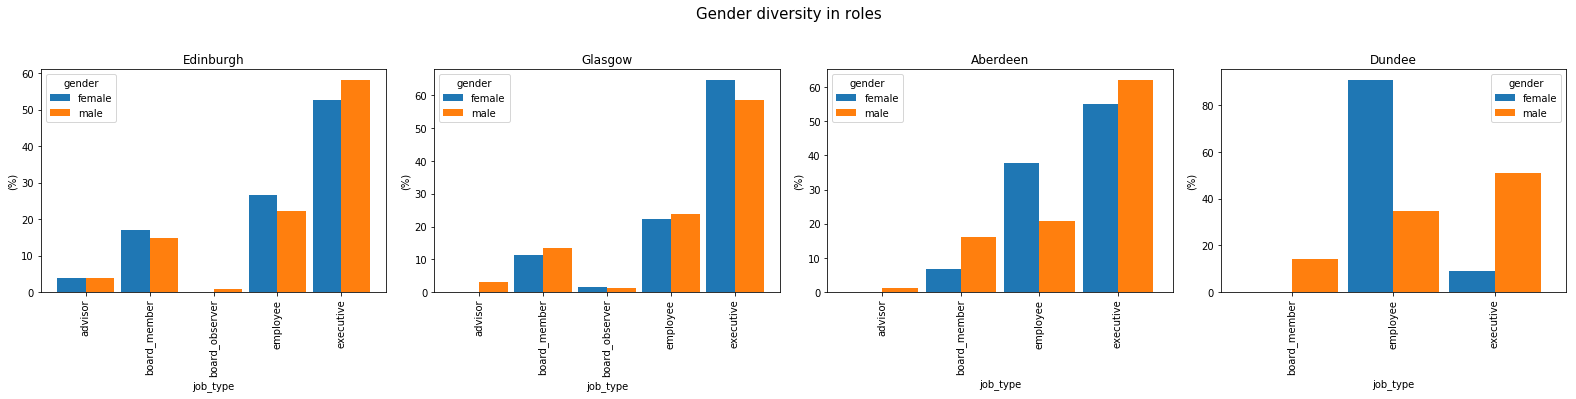

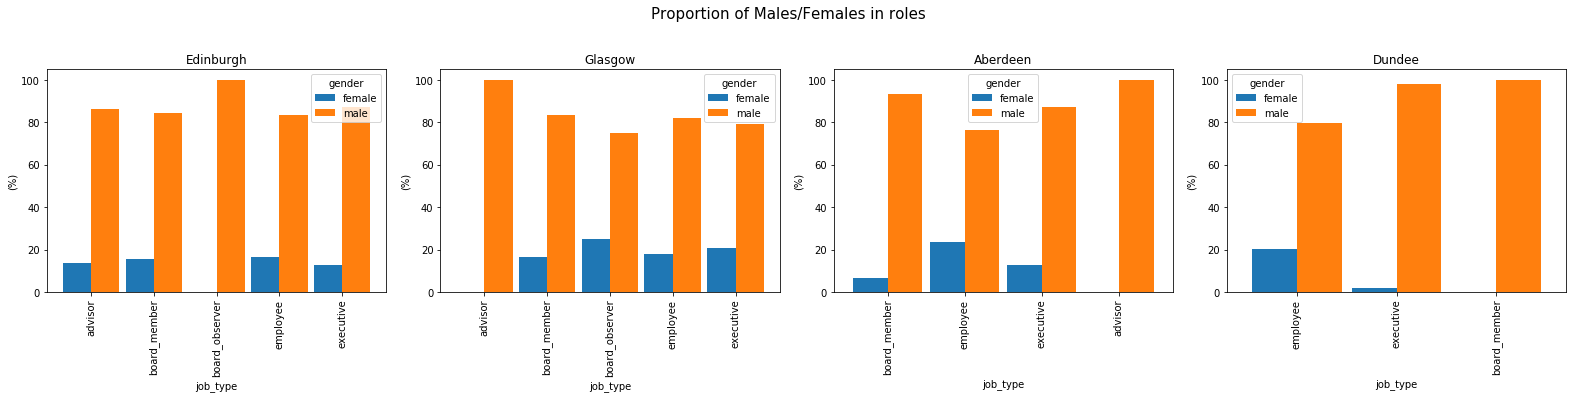

In [13]:
fig1 = plt.figure(figsize=(22, 5))
gs = gridspec.GridSpec(1,4)
for i, country in enumerate(country_gender.index.levels[0][:4]):
    ax = plt.subplot(gs[0,i])
    role_comp_gender.loc[country].unstack('gender')[['female', 'male']].plot(kind='bar', width=0.9, ax=ax)
    ax.set_title('{}'.format(country))
    ax.set_ylabel('(%)')

plt.suptitle('Gender diversity in roles', fontsize=15, y=1.1)
plt.tight_layout()

fig2 = plt.figure(figsize=(22, 5))
gs = gridspec.GridSpec(1,4)
for i, country in enumerate(country_gender.index.levels[0][:4]):
    ax = plt.subplot(gs[0,i])
    ind.city_role_company('city', 'gender', 'job_type').loc[country].unstack('gender')[['female', 'male']].plot(kind='bar', width=0.9, ax=ax)
    ax.set_title('{}'.format(country))
    ax.set_ylabel('(%)')

plt.suptitle('Proportion of Males/Females in roles', fontsize=15, y=1.1)
plt.tight_layout()

plt.show()

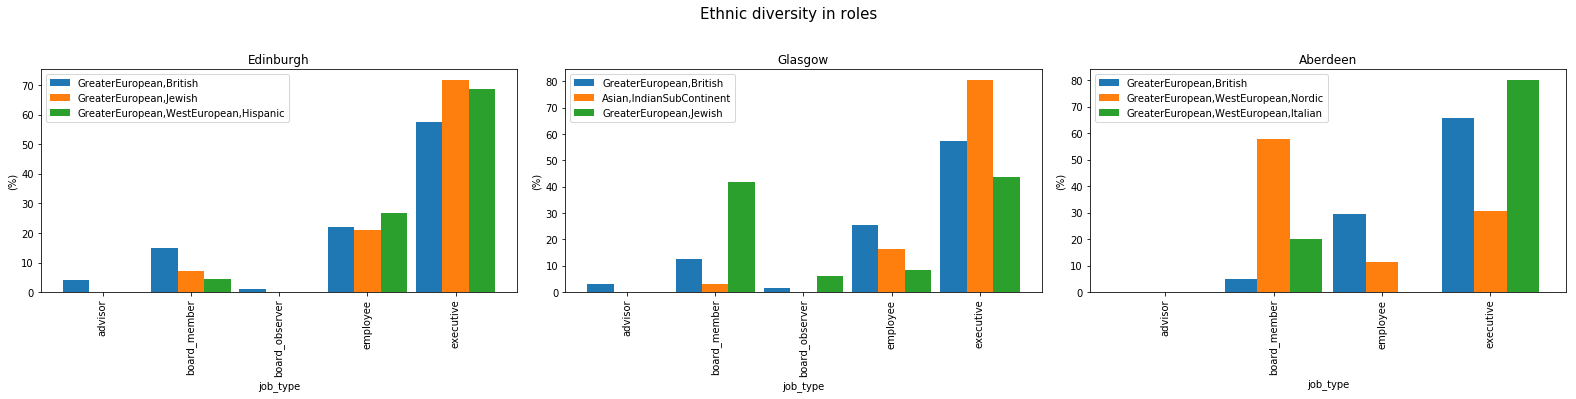

In [14]:
fig = plt.figure(figsize=(22, 5))
gs = gridspec.GridSpec(1,3)
for i, country in enumerate(country_gender.index.levels[0][:3]):
    ax = plt.subplot(gs[0,i])
    role_comp_ethnicity.loc[country].unstack('race')[[v for v in df[df.city==country].race.value_counts().index.values[:3]]].plot(kind='bar', width=0.9, ax=ax, legend=False)
    ax.set_title('{}'.format(country))
    ax.legend(loc='best')
    ax.set_ylabel('(%)')

plt.suptitle('Ethnic diversity in roles', fontsize=15, y=1.1)
plt.tight_layout()
plt.show()

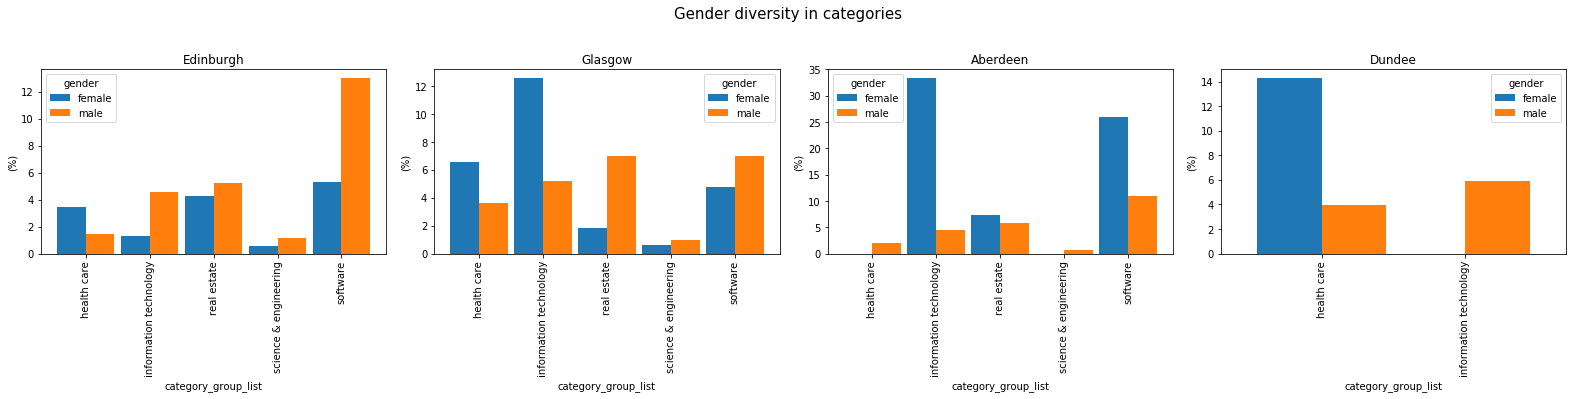

In [15]:
cats = df.drop_duplicates('org_id')['category_group_list'].value_counts().index[:5]
fig = plt.figure(figsize=(22, 5))
gs = gridspec.GridSpec(1,4)
for i, country in enumerate(country_gender.index.levels[0][:4]):
    ax = plt.subplot(gs[0,i])
    cat_comp_gender.loc[country].loc[cats].unstack('gender')[['female', 'male']].plot(kind='bar', width=0.9, ax=ax)
    ax.set_xticklabels(['health care', 'information technology', 'real estate', 'science & engineering', 'software'])
    ax.set_title('{}'.format(country))
    ax.set_ylabel('(%)')

plt.suptitle('Gender diversity in categories', fontsize=15, y=1.1)
plt.tight_layout()
plt.show()

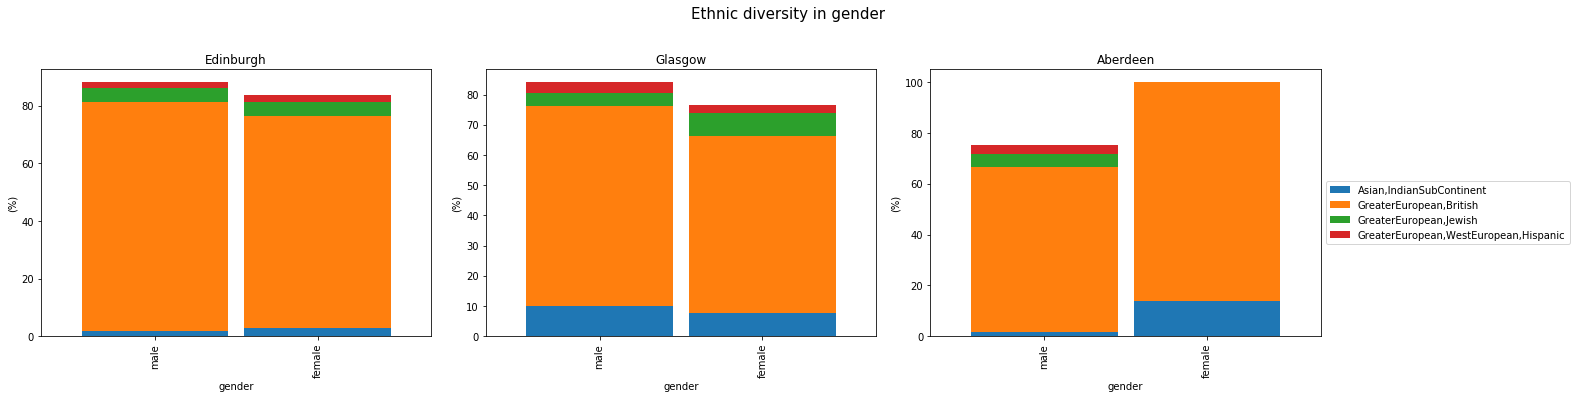

In [16]:
fig = plt.figure(figsize=(22, 5))
gs = gridspec.GridSpec(1,3)
for i, country in enumerate(country_gender.index.levels[0][:3]):
    ax = plt.subplot(gs[0,i])
    country_race_gender.loc[country][[v for v in df[df.city=='Edinburgh'].race.value_counts().index.values[:4]]].unstack('race').loc[['male', 'female']].plot(kind='bar', width=0.9, ax=ax, stacked=True, legend=False)
    ax.set_title('{}'.format(country))
    ax.set_ylabel('(%)')
    
    if i == 2:
        ax.legend(bbox_to_anchor=(1, 0.6))

plt.suptitle('Ethnic diversity in gender', fontsize=15, y=1.1)
plt.tight_layout()
plt.show()

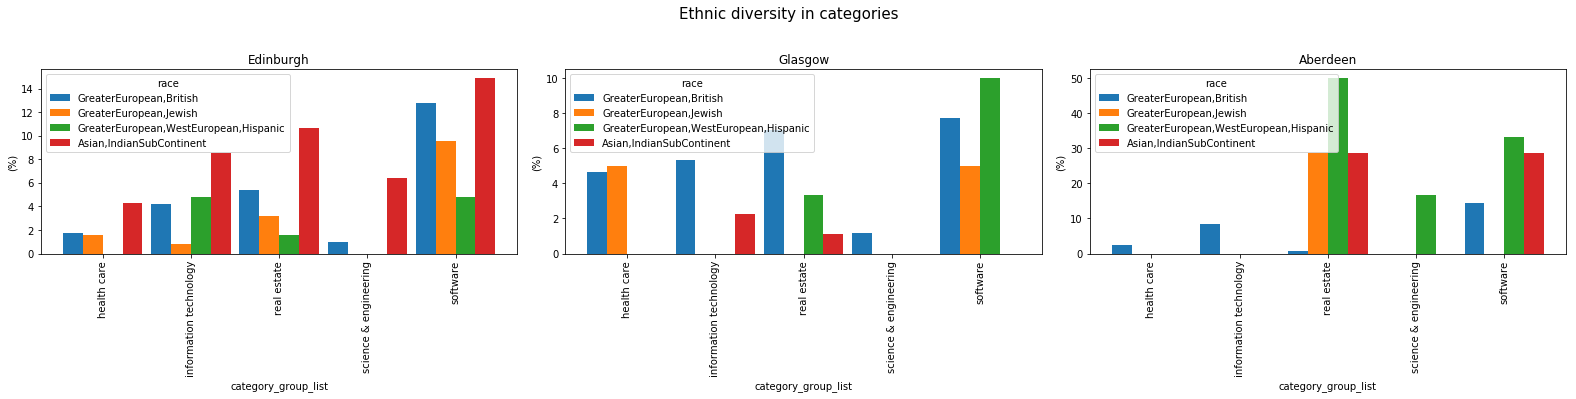

In [17]:
cats = df.drop_duplicates('org_id')['category_group_list'].value_counts().index[:5]
fig = plt.figure(figsize=(22, 5))
gs = gridspec.GridSpec(1,3)
for i, country in enumerate(country_gender.index.levels[0][:3]):
    ax = plt.subplot(gs[0,i])
    cat_comp_ethnicity.loc[country].loc[cats].unstack('race')[[v for v in df[df.city=='Edinburgh'].race.value_counts().index.values[:4]]].plot(kind='bar', width=0.9, ax=ax, legend=True)
    ax.set_xticklabels(['health care', 'information technology', 'real estate', 'science & engineering', 'software'])
    ax.set_title('{}'.format(country))
    ax.set_ylabel('(%)')

plt.suptitle('Ethnic diversity in categories', fontsize=15, y=1.1)
plt.tight_layout()
plt.show()

### Indicators 9 & 10

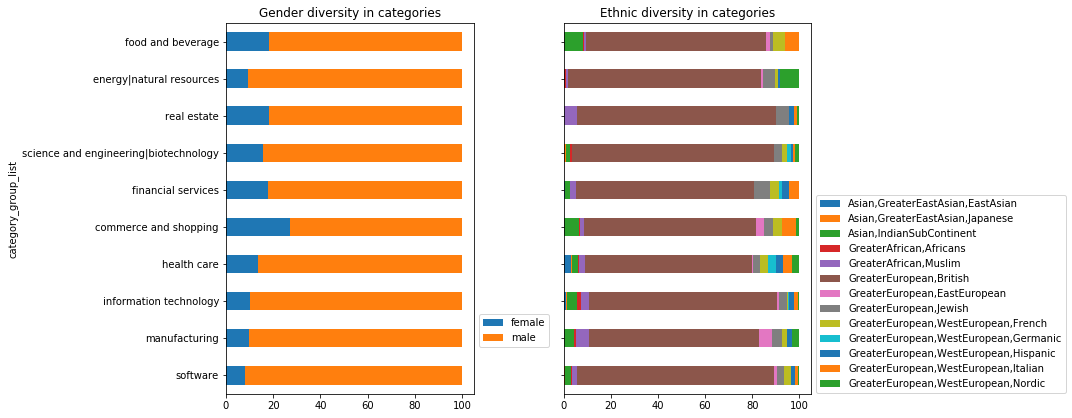

In [18]:
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(1,2)
idx = df.drop_duplicates('org_id')['category_group_list'].value_counts().index[:10]
i = pd.IndexSlice
# ax1
ax1 = plt.subplot(gs[0,0])
# cg = cat_gender / cat_gender.groupby('category_group_list').sum()
cat_gender.reindex(idx, level=0).loc[i[idx[:10], :], ].unstack().plot(kind='barh', stacked=True, ax=ax1)
ax1.set_title('Gender diversity in categories', fontsize=12)
ax1.legend(bbox_to_anchor=(1, 0.23))

# ax2
ax2 = plt.subplot(gs[0,1])
# ce = cat_ethnicity / cat_ethnicity.groupby('category_group_list').sum()
cat_ethnicity.reindex(idx, level=0).loc[i[idx[:10], :], ].unstack().plot(kind='barh', stacked=True, ax=ax2)
ax2.set_title('Ethnic diversity in categories', fontsize=12)
ax2.set_yticklabels([])
ax2.set_ylabel('')
ax2.legend(bbox_to_anchor=(1, 0.55))

plt.tight_layout()
plt.show()

### Indicators 11

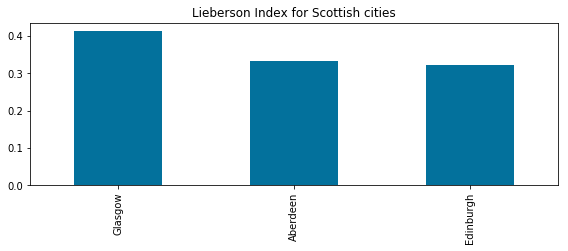

In [21]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2,1)

ax2 = plt.subplot(gs[1,:])
pd.DataFrame.from_dict(lieberson_index_cities, orient='index').sort_values(0, ascending=False)[:20].plot(kind='bar', ax=ax2, color='xkcd:ocean blue', legend=False)
ax2.set_title('Lieberson Index for Scottish cities', fontsize=12)

plt.tight_layout()
plt.show()

### Indicators 13 & 14

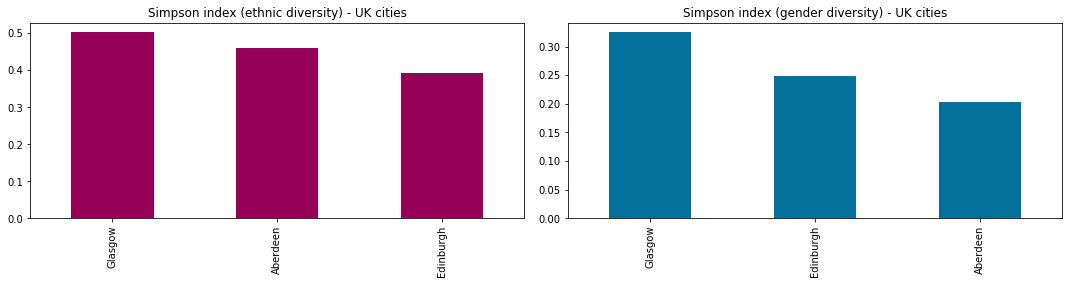

In [20]:
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(3,2)

# ax3
ax3 = plt.subplot(gs[2,0])
pd.DataFrame.from_dict(simpson_ethnic_city, orient='index').sort_values(by=0, ascending=False).plot(kind='bar', legend=False, color='xkcd:dark magenta', ax=ax3)
ax3.set_title('Simpson index (ethnic diversity) - UK cities', fontsize=12)

# ax4
ax4 = plt.subplot(gs[2,1])
pd.DataFrame.from_dict(simpson_gender_city, orient='index').sort_values(by=0, ascending=False).plot(kind='bar', legend=False, color='xkcd:ocean blue', ax=ax4)
ax4.set_title('Simpson index (gender diversity) - UK cities', fontsize=12)

plt.tight_layout()
plt.show()